In [46]:
import os
import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path + '\\MSongDB\PythonSrc')
sys.path.insert(0,'../MSongsDB/PythonSrc')
import hdf5_getters
import h5py
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
import pandas as pd


In [4]:
spark_session = SparkSession.builder\
.master("spark://192.168.2.129:7077")\
.appName("Analysis_emil")\
.config("spark.dynamicAllocation.enabled", False)\
.config("spark.dynamicAllocation.shuffleTracking.enabled",False)\
.config("spark.shuffle.service.enabled", False)\
.config("spark.dynamicAllocation.executorIdleTimeout","30s")\
.config("spark.cores.max", 4)\
.getOrCreate()

spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/14 15:07:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark_session.read.csv("hdfs://192.168.2.129:50000/hdfs/data/SongCSV_A.csv", header=True)
df.show()

+----------+------------------+-------+--------------------+--------------------+--------------+--------------------+---------------+--------------------+------------+---------+------------+----------------------+-------+-------------+-----------------------+--------------------+----+
|SongNumber|            SongID|AlbumID|           AlbumName|            ArtistID|ArtistLatitude|      ArtistLocation|ArtistLongitude|          ArtistName|Danceability| Duration|KeySignature|KeySignatureConfidence|  Tempo|TimeSignature|TimeSignatureConfidence|               Title|Year|
+----------+------------------+-------+--------------------+--------------------+--------------+--------------------+---------------+--------------------+------------+---------+------------+----------------------+-------+-------------+-----------------------+--------------------+----+
|         1|SOMZWCG12A8C13C480| 300848|      b'Fear Itself'|b'ARD7TVE1187B99B...|          null|  b'California - LA'|           null|         

In [6]:
df.printSchema()

root
 |-- SongNumber: string (nullable = true)
 |-- SongID: string (nullable = true)
 |-- AlbumID: string (nullable = true)
 |-- AlbumName: string (nullable = true)
 |-- ArtistID: string (nullable = true)
 |-- ArtistLatitude: string (nullable = true)
 |-- ArtistLocation: string (nullable = true)
 |-- ArtistLongitude: string (nullable = true)
 |-- ArtistName: string (nullable = true)
 |-- Danceability: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- KeySignature: string (nullable = true)
 |-- KeySignatureConfidence: string (nullable = true)
 |-- Tempo: string (nullable = true)
 |-- TimeSignature: string (nullable = true)
 |-- TimeSignatureConfidence: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)



In [49]:
data1 = df.select("Duration","KeySignature","Tempo","Year").filter(df["Year"]!=0)
data1 = data1.select(*(col(c).cast("float").alias(c) for c in data1.columns))
mean_data = data1.groupBy("Year").mean()
data2 = Window.partitionBy("Year")
data3 = data1.withColumn("Mean Duration", avg("Duration").over(data2))
data3 = data3.withColumn("Mean Key", avg("KeySignature").over(data2))
data3 = data3.withColumn("Mean Tempo", avg("Tempo").over(data2))
data3.show()

+---------+------------+-------+------+------------------+-----------------+------------------+
| Duration|KeySignature|  Tempo|  Year|     Mean Duration|         Mean Key|        Mean Tempo|
+---------+------------+-------+------+------------------+-----------------+------------------+
|175.15057|         4.0|101.676|1926.0| 176.7701644897461|              2.5|101.00250244140625|
|178.38976|         1.0|100.329|1926.0| 176.7701644897461|              2.5|101.00250244140625|
|188.94322|         4.0| 99.076|1927.0|188.69941202799478|5.666666666666667| 131.0653305053711|
|191.73833|         3.0|131.624|1927.0|188.69941202799478|5.666666666666667| 131.0653305053711|
|185.41669|        10.0|162.496|1927.0|188.69941202799478|5.666666666666667| 131.0653305053711|
|191.11137|         6.0|114.177|1929.0| 191.1113739013672|              6.0|  114.177001953125|
|196.62321|        10.0|107.877|1930.0| 196.7538299560547|              5.0| 133.3219985961914|
|196.88445|         0.0|158.767|1930.0| 

In [50]:
year = mean_data.rdd.map(lambda x: x["Year"]).collect()
dur = mean_data.rdd.map(lambda x: x["avg(Duration)"]).collect()
key = mean_data.rdd.map(lambda x: x["avg(KeySignature)"]).collect()
temp = mean_data.rdd.map(lambda x: x["avg(Tempo)"]).collect()


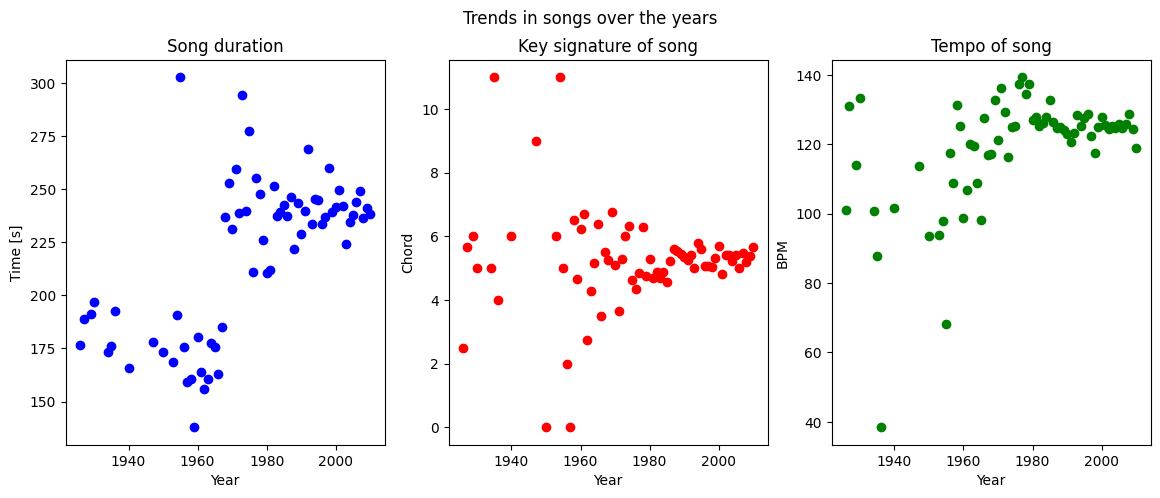

In [52]:
plt.figure(figsize=(14, 5))

plt.subplot(131)
plt.scatter(year, dur, c='b')
plt.title("Song duration")
plt.xlabel("Year")
plt.ylabel("Time [s]")
plt.subplot(132)
plt.scatter(year, key, c='r')
plt.title("Key signature of song")
plt.xlabel("Year")
plt.ylabel("Chord")
plt.subplot(133)
plt.scatter(year, temp, c='g')
plt.title("Tempo of song")
plt.xlabel("Year")
plt.ylabel("BPM")
plt.suptitle('Trends in songs over the years')
plt.show()

In [29]:
pd_data = df.pandas_api()
pd_num = pd_data[["AlbumID","Danceability","Duration","KeySignature","Tempo","Year"]]
#pd.to_numeric(pd_num, errors='coerce')
pd_num = pd_num.astype('float')
pd_num.shape

(10000, 6)

In [53]:
spark_session.stop()